# Train MPOX detection models

Based on theh paper *"Deep learning based detection of monkeypox virus using skin lesion images"* by T. Nayak et al., 2023

Will fine tune a CNN model:
- Dataset: [MSLD-v1](https://github.com/mHealthBuet/Monkeypox-Skin-Lesion-Dataset)
    - Binary: Monkeypox, Others (chickenpox and measles)
    - 224 x 224 x 3
	- 228 original images (102 'Monkeypox'; 126 'Others'). 
	- augmented to 3,192 images (1,428 'Monkeypox'; 1764 in 'Others').
- Pretrained model: ResNet-18 trained with Imagenet-1k
- Hyperparameters:
	- BS: [16 32 64]
	- LR:  [0.01 0.001]
    - nbr epochs: 200

## Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import re
import torch
import umap

from pprint import pprint
from uuid import uuid4
from IPython.display import Markdown, display

from eccore.ipython import nb_setup
nb_setup()

from fastai.vision.all import *
from fastai.callback.all import ShowGraphCallback
# from torchvision.models import resnet18, ResNet18_Weights
from fastai import __version__ as fastai_version
from pathlib import Path
from utils import run_experiment, create_image_features, plot_features, parse_saved_fnames, ROOT, DATASETS
from utils import validate_models, plot_training_and_validation_metrics, model_weight_files

print(f"Using fastai version {fastai_version}")

root = Path(str(Path().resolve()).replace('/nbs',''))
assert root.is_dir(), f"Root path {root} is not a directory."

saved = root / "saved"
assert saved.is_dir()
data = root / "data"
assert data.is_dir()
msld = data / "MSLD-v1"
assert msld.is_dir()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Added path: /home/vtec/projects/bio/mpox-prestudy/src
Set autoreload mode
Using fastai version 2.8.3
Using device: cuda


In [2]:
files_original = get_image_files(msld/'Original')
files_original_mpox = get_image_files(msld/'Original/Monkeypox')
files_original_others = get_image_files(msld/'Original/Others')
print(f"Original:  {len(files_original):5,d} images found including {len(files_original_mpox):5,d} Monkeypox and {len(files_original_others):5,d} Others images")
files_augmented = get_image_files(msld/'Augmented')
files_augmented_mpox = get_image_files(msld/'Augmented/Monkeypox')
files_augmented_others = get_image_files(msld/'Augmented/Others')
print(f"Augmented: {len(files_augmented):5,d} images found including {len(files_augmented_mpox):5,d} Monkeypox and {len(files_augmented_others):5,d} Others images")

print('Fold1:')
files_train = get_image_files(msld/'Fold1/Train')
print(f"   {len(files_train):5,d} train images")
files_val = get_image_files(msld/'Fold1/Val')
print(f"   {len(files_val):5,d} validation images")
files_test = get_image_files(msld/'Fold1/Test')
print(f"   {len(files_test):5,d} test images")
print(f"   {len(files_train) + len(files_val) + len(files_test):5,d} images in Fold1")

Original:    228 images found including   102 Monkeypox and   126 Others images
Augmented: 3,192 images found including 1,428 Monkeypox and 1,764 Others images
Fold1:
   2,142 train images
     420 validation images
      45 test images
   2,607 images in Fold1


## Create Training dataloader and utility fn

In [13]:
# ImageDataLoaders.from_folder?

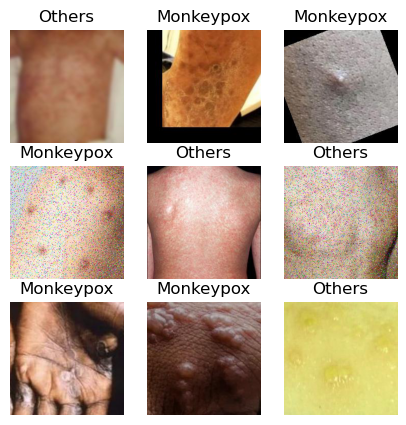

In [14]:
dls = ImageDataLoaders.from_folder(
    path=msld/'Augmented',
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=32
)
plt.style.use('default')
dls.show_batch(max_n=9, figsize=(5,5), show=True)

In [15]:
# run_experiment(resnet18, dls=dls, freeze_epochs=1, n_epoch=200, lr=1e-3, bs=32, dls=dls, suggested_lr='minimum')

## Explore paper's hyperparameters

| # | lr | bs | Train Loss | Val Acc | Val Loss | Val Recall  | Val Specificity | Val Precision | Val Acc | Val F1 |
| - | -  | -  | -          | -       | -        | -           | -               | -             | -       | -      |
| 1 |1e-3| 32 |  1.33E-06  | 99.4987 | 0.0375   | 0.988795518 | 1               | 1             | 0.994987469 | 0.994366197 |
| 2 |1e-3| 16 |  1.71E-07  | 99.4987 | 0.0235   | 0.994397759 | 0.995464853     | 0.994397759   | 0.994987469 | 0.994397759 |
| 3 |1e-3| 64 |  1.51E-05  | 97.7444 | 0.0784   | 0.969187675 | 0.984126984     | 0.980169972   | 0.977443609 | 0.974647887 |
| 4 |1e-4| 32 |  1.00E-03  | 97.619  | 0.0662   | 0.966386555 | 0.984126984     | 0.980113636   | 0.976190476 | 0.973201693 |


### Finetuning

Running experiment 1/4: bs=32; lr=1.0e-03
> Fine-tuning resnet18 on msld-v1 for 2 epochs with batch size 32...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.739749,0.403347,0.868263,0.830946,0.838558,0.849195,00:04


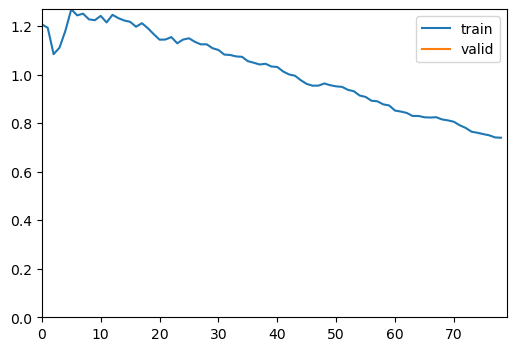

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.380153,0.186616,0.946108,0.905444,0.920063,0.925329,00:04
1,0.209396,0.154633,0.973054,0.912921,0.937304,0.942029,00:04


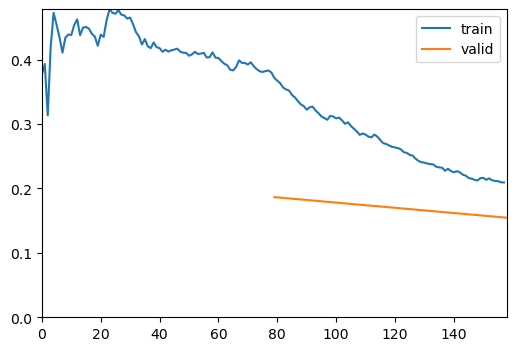

> Trining records not saved
----------------------------------------

Running experiment 2/4: bs=16; lr=1.0e-03
> Fine-tuning resnet18 on msld-v1 for 2 epochs with batch size 16...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.760491,0.387851,0.925150,0.828418,0.860502,0.874116,00:03


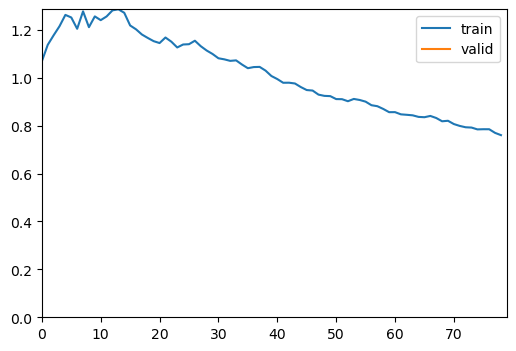

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.368680,0.222135,0.958084,0.879121,0.909091,0.916905,00:04
1,0.199219,0.164419,0.958084,0.924855,0.937304,0.941176,00:04


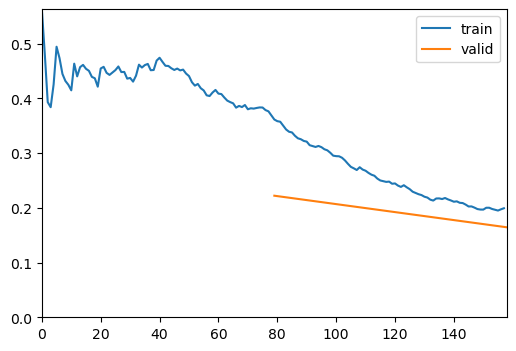

> Trining records not saved
----------------------------------------

Running experiment 3/4: bs=64; lr=1.0e-03
> Fine-tuning resnet18 on msld-v1 for 2 epochs with batch size 64...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.790883,0.370503,0.874251,0.848837,0.852665,0.861357,00:03


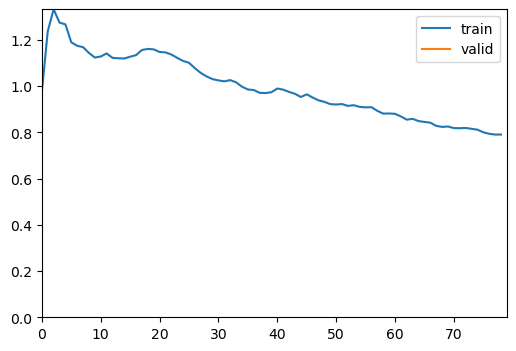

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.381167,0.241754,0.952096,0.898305,0.918495,0.924419,00:04
1,0.245459,0.174379,0.946108,0.940476,0.940439,0.943284,00:04


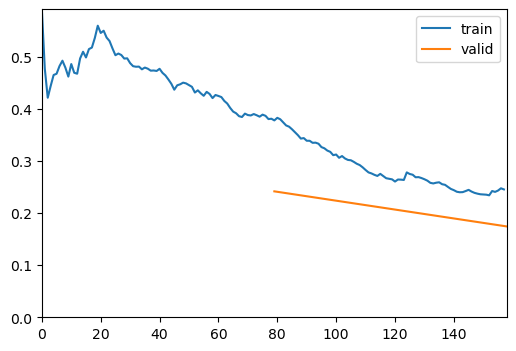

> Trining records not saved
----------------------------------------

Running experiment 4/4: bs=32; lr=1.0e-04
> Fine-tuning resnet18 on msld-v1 for 2 epochs with batch size 32...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,1.019547,0.607570,0.706587,0.721713,0.703762,0.714070,00:03


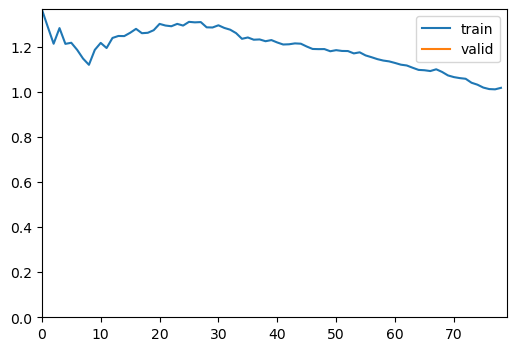

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.755620,0.482538,0.796407,0.784661,0.778997,0.790490,00:04
1,0.693306,0.444411,0.805389,0.807808,0.797806,0.806597,00:04


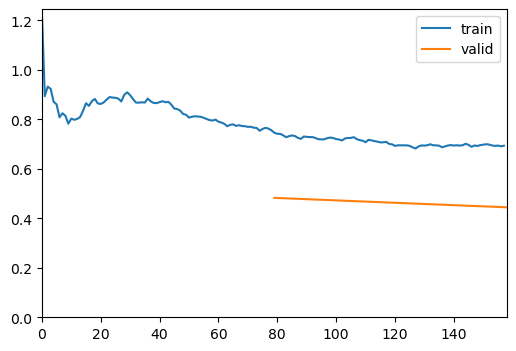

> Trining records not saved
----------------------------------------



In [16]:
freeze_epochs = 1
n_epoch = 2
SAVE_RECORDS = True
SAVE_RECORDS = False

hyperparams = (
    (1e-3, 32),
    (1e-3,16),
    (1e-3,64),
    (1e-4,32)
)
stats = []

for i, (lr, bs) in enumerate(hyperparams):
    print(f"Running experiment {i+1}/{len(hyperparams)}: bs={bs}; lr={lr:<.1e}")
    learn = run_experiment(
        resnet18,
        dls=dls,
        dataset='msld-v1',
        freeze_epochs=freeze_epochs, 
        n_epoch=n_epoch, 
        lr=lr, bs=bs,
        save_records=SAVE_RECORDS
    )
    print(f"{'-'*40}\n")

## Validation

In [3]:
selected_arch = resnet18
training_ds = 'msld-v1'
validation_ds = 'msid-binary'

training_res_df, validation_res_df = validate_models(
    arch=selected_arch,
    training_ds=training_ds,
    validation_ds=validation_ds,
)

Found 3,192 images in training dataset MSLD-v1.
Found 770 images in validation dataset MSID Binary.
Found 4 model weight files
Validating model with weights from resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b


Validating model with weights from resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8


Validating model with weights from resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a


Validating model with weights from resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf


### Metrics while fine-tuning `resnet18` models:

Fine-tuned on 80% of `MSLD-v1` image dataset and validated on 20%

,train_val_recall,train_val_precision,train_val_accuracy,train_val_f1
resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b,0.994366,0.980556,0.985893,0.987413
resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8,1.000000,0.967302,0.981191,0.983380
resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a,0.997183,0.983333,0.989028,0.0
resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf,0.997183,0.972527,0.982759,0.984701


### Validation of fine-tuned `resnet18` models:

Validated on `MSID Binary` image dataset

,recall,precision,accuracy,f1
resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b,0.712360,0.887955,0.757576,0.790524
resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8,0.782022,0.857143,0.776335,0.817861
resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a,0.723596,0.858667,0.746032,0.785366
resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf,0.734831,0.891008,0.772006,0.805419


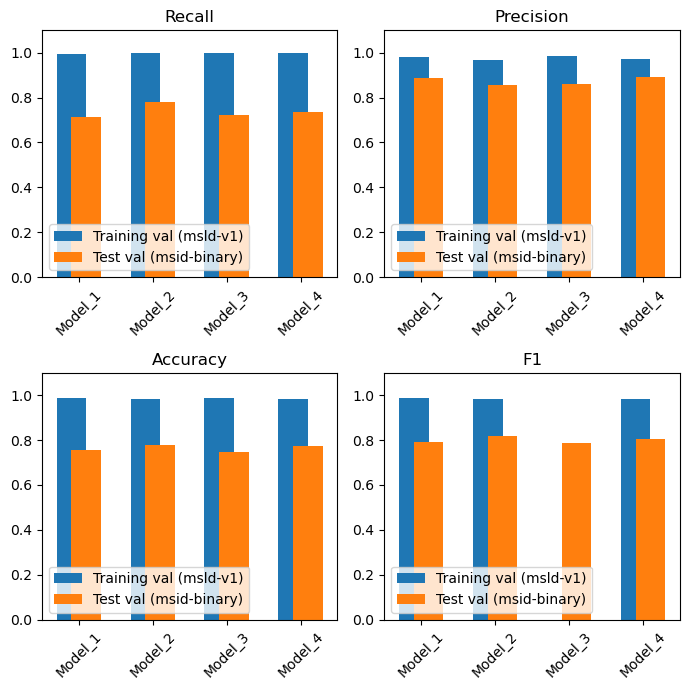

In [5]:
plot_training_and_validation_metrics(training_res_df, validation_res_df)

## Review Image Features

## Using resnet18 models

In [6]:
selected_arch = resnet18
dataset = 'msld-v1'

saved_model_files = model_weight_files(arch=selected_arch, dataset=dataset)
saved_model_files

[Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf.pth')]

In [11]:
datasets = ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
dataset_paths=[DATASETS[k]['path'] for k in datasets]

features, labels = create_image_features(
    saved_model_file=saved_model_files[0],
    selected_arch=selected_arch,
    dataset_paths=dataset_paths
)
features.shape, labels.shape, np.unique(labels)

Extracting image features using model resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b.pth ...
> Extracting features for 3,192 images in /home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented in batches of 8 images ...
> Extracting features for 770 images in /home/vtec/projects/bio/mpox-prestudy/data/MSID-binary in batches of 128 images ...
> Extracting features for 43 images in /home/vtec/projects/bio/mpox-prestudy/data/Monkeypox-dataset-2022/Monkeypox in batches of 8 images ...


((4005, 1024), (4005,), array([0, 1, 4, 5, 8]))

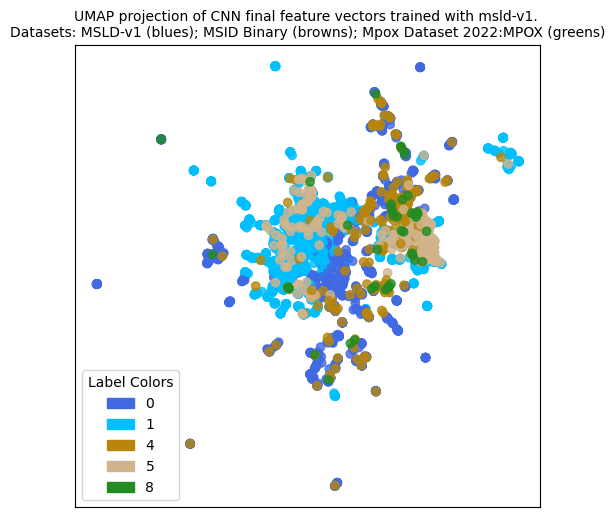

In [13]:
reducer = umap.UMAP()
reducer.fit(features)
embedding = reducer.transform(features)

ds_dict = {
    'training': 'msld-v1',
    'features': ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
}
plot_features(embedding, labels, ds_dict)

Extracting image features using model resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b.pth ...
> Extracting features for 3,192 images in /home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented in batches of 8 images ...
> Extracting features for 770 images in /home/vtec/projects/bio/mpox-prestudy/data/MSID-binary in batches of 128 images ...
> Extracting features for 43 images in /home/vtec/projects/bio/mpox-prestudy/data/Monkeypox-dataset-2022/Monkeypox in batches of 8 images ...
Extracting image features using model resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8.pth ...
> Extracting features for 3,192 images in /home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented in batches of 8 images ...
> Extracting features for 770 images in /home/vtec/projects/bio/mpox-prestudy/data/MSID-binary in batches of 128 images ...
> Extracting features for 43 images in /home/vtec/projects/bio/mpox-prestudy/data/Monkeypox-dataset-2022

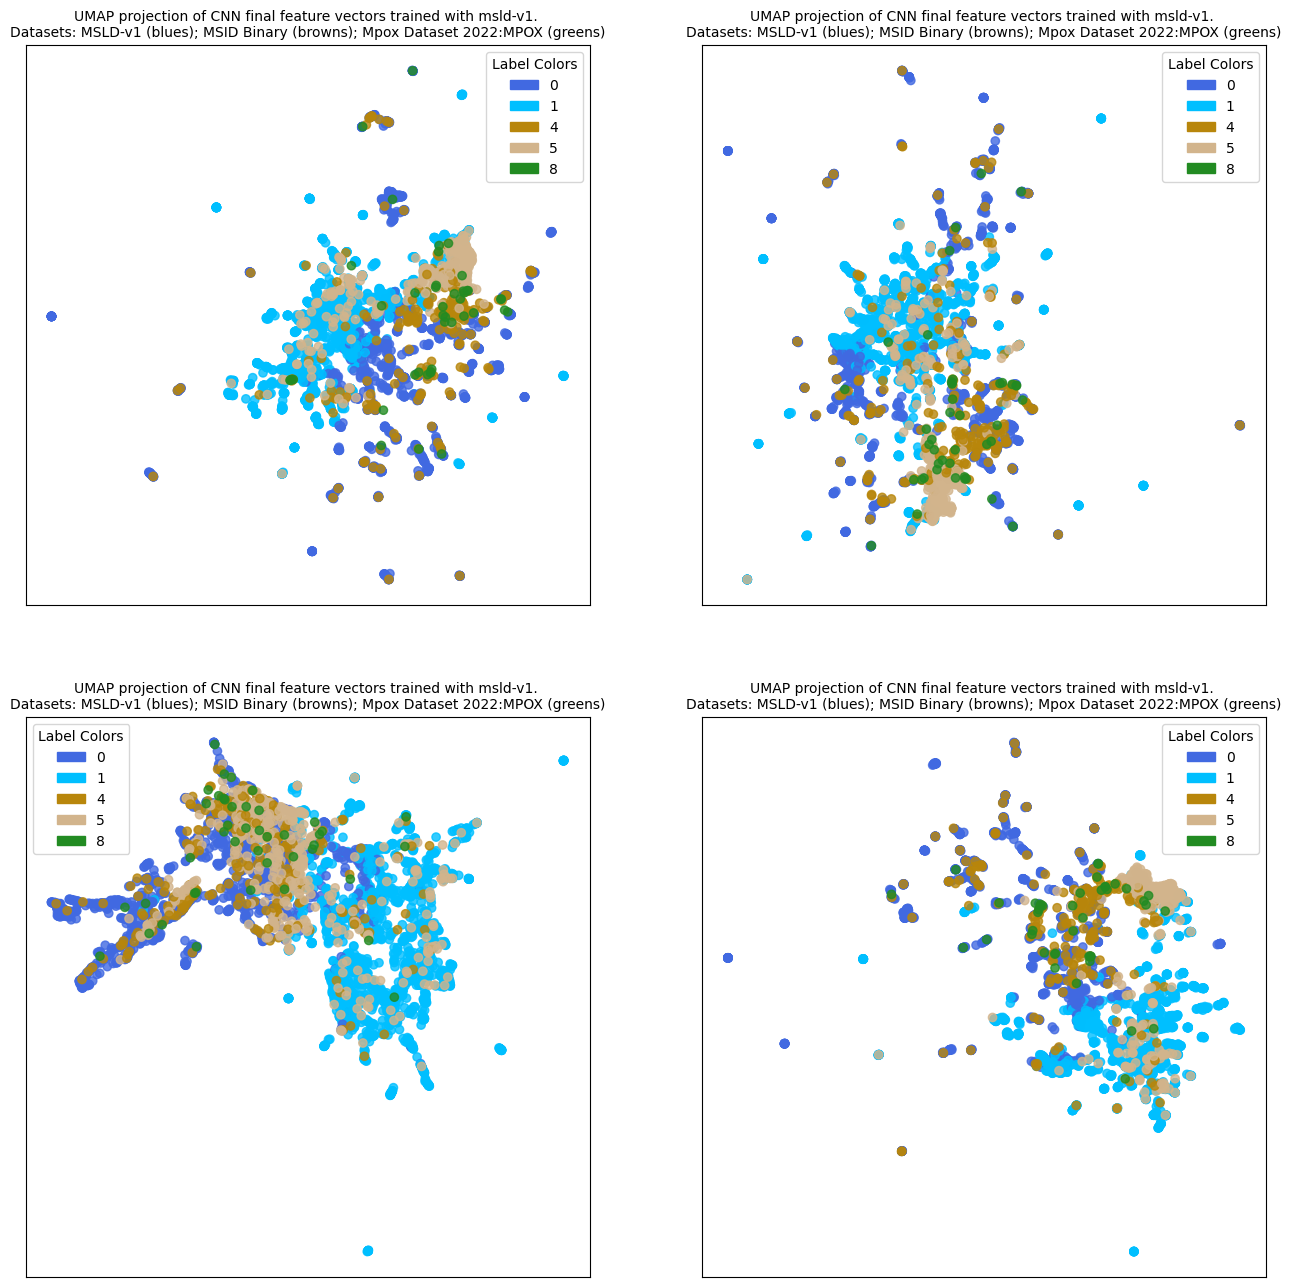

In [14]:
nb_models = len(saved_model_files)
datasets = ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
dataset_paths=[DATASETS[k]['path'] for k in datasets]
ds_dict = {
    'training': 'msld-v1',
    'features': datasets
}

ncols = 2
nrows = (nb_models + ncols - 1) // ncols  # Calculate number of rows needed
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), sharex=False, sharey=False)
axs = axs.flatten() if nb_models > 1 else [axs]
for ax,model_file in zip(axs,saved_model_files):
    features, labels = create_image_features(
        saved_model_file=model_file,
        selected_arch=selected_arch,
        dataset_paths=dataset_paths,
    )
    reducer = umap.UMAP()
    reducer.fit(features)
    embedding = reducer.transform(features)
    plot_features(embedding, labels, ds_dict, ax=ax)

## Using densenet169

In [15]:
selected_arch = densenet169
dataset = 'msld-v1'

saved_model_files = model_weight_files(arch=selected_arch, dataset=dataset)
saved_model_files

[Path('/home/vtec/projects/bio/mpox-prestudy/saved/densenet169_100_64_1.0e-03_msld-v1_weights_fc22a3ac-15c0-4a48-8bab-3a1397ddcb3c.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/densenet169_200_32_1.0e-03_msld-v1_weights_0657fcbb-18da-4c00-855e-3f530184e78d.pth'),
 Path('/home/vtec/projects/bio/mpox-prestudy/saved/densenet169_200_16_1.0e-03_msld-v1_weights_15de44b2-0301-4a2d-8791-07f0b84b8ec0.pth')]

In [16]:
datasets = ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
dataset_paths=[DATASETS[k]['path'] for k in datasets]

features, labels = create_image_features(
    saved_model_file=saved_model_files[0],
    selected_arch=selected_arch,
    dataset_paths=dataset_paths
)
features.shape, labels.shape, np.unique(labels)

Extracting image features using model densenet169_100_64_1.0e-03_msld-v1_weights_fc22a3ac-15c0-4a48-8bab-3a1397ddcb3c.pth ...
> Extracting features for 3,192 images in /home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented in batches of 8 images ...
> Extracting features for 770 images in /home/vtec/projects/bio/mpox-prestudy/data/MSID-binary in batches of 128 images ...
> Extracting features for 43 images in /home/vtec/projects/bio/mpox-prestudy/data/Monkeypox-dataset-2022/Monkeypox in batches of 8 images ...


((4005, 3328), (4005,), array([0, 1, 4, 5, 8]))

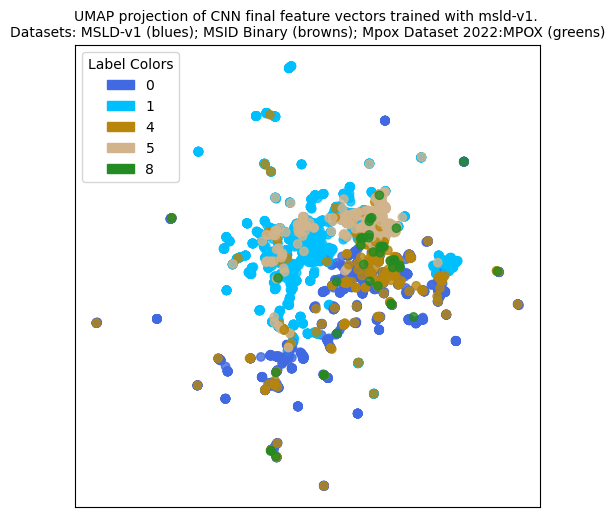

In [17]:
reducer = umap.UMAP()
reducer.fit(features)
embedding = reducer.transform(features)

ds_dict = {
    'training': 'msld-v1',
    'features': ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
}
plot_features(embedding, labels, ds_dict)

In [ ]:
nb_models = len(saved_model_files)
datasets = ['msld-v1', 'msid-binary', 'mpox-ds-2022:mpox']
dataset_paths=[DATASETS[k]['path'] for k in datasets]
ds_dict = {
    'training': 'msld-v1',
    'features': datasets
}

ncols = 2
nrows = (nb_models + ncols - 1) // ncols  # Calculate number of rows needed
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), sharex=False, sharey=False)
axs = axs.flatten() if nb_models > 1 else [axs]
for ax,model_file in zip(axs,saved_model_files):
    features, labels = create_image_features(
        saved_model_file=model_file,
        selected_arch=selected_arch,
        dataset_paths=dataset_paths,
    )
    reducer = umap.UMAP()
    reducer.fit(features)
    embedding = reducer.transform(features)
    plot_features(embedding, labels, ds_dict, ax=ax)

## can be deleted

In [ ]:
nb_models = len(saved_model_files)
dataset_paths=['MSLD-v1/Original', 'MSID-binary', 'Monkeypox-dataset-2022/Monkeypox']
datasets = ['MSLD-v1', 'MSID-binary', 'Monkeypox-ds-2022-mpox']

ncols = 2
nrows = (nb_models + ncols - 1) // ncols  # Calculate number of rows needed
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), sharex=False, sharey=False)
axs = axs.flatten() if nb_models > 1 else [axs]
for ax,model_file in zip(axs,saved_model_files):
    print(model_file.name)
    features, labels = create_image_features(
        saved_model_file=model_file,
        selected_arch=selected_arch,
        dataset_paths=dataset_paths,
        data_dir=data,
        verbose=False
    )
    reducer = umap.UMAP()
    reducer.fit(features)
    embedding = reducer.transform(features)
    plot_features(embedding, labels, ax=ax, training_ds=datasets[0])

densenet169_100_64_1.0e-03_msld-v1_weights_fc22a3ac-15c0-4a48-8bab-3a1397ddcb3c.pth


# Others

In [21]:
from PIL import Image

In [43]:
p2img_dir = data / 'MSLD-v1/Original/Monkeypox'

# img = Image.open(p2img_dir / 'M01_01.jpg')
# img = Image.open(p2img_dir / 'M08_01.jpg')
img = Image.open(p2img_dir / 'M26_01.jpg')
# img = Image.open(p2img_dir / 'M49_02.jpg')
print(img.size)
img_384 = img.resize((384, 384), Image.LANCZOS)
img_384.save(data / f"{Path(img.filename).stem}_384.jpg")
img_1024 = img.resize((1024, 1024), Image.LANCZOS)
img_1024.save(data / f"{Path(img.filename).stem}_1024.jpg")

(224, 224)
